**Prototyping Pandera validator library for NTD reporting data**
https://github.com/unionai-oss/pandera  
  
This notebook first imports a csv of cleaned data, presumably submitted from the A10 form, from the NTD data files found on their website. The data was transformed in the notebook `clean_format_data.ipynb`

In [2]:
import pandas as pd
import pandera as pa
import numpy as np 

In [3]:
# data to validate -

df = pd.read_csv("data/2021_a10_submitted_partialdata.csv", index_col = 0) # A-10
df.head(3)

,Agency,City,State,Organization Type,Reporter Type,Mode,TOS,ownerships,Under 200 Vehicles,200 to 300 Vehicles,Over 300 Vehicles,Heavy Maintenance Facilities,Total Facilities
0,Los Angeles County Metropolitan Transportation...,Los Angeles,CA,Independent Public Agency or Authority of Tran...,Full Reporter,MB,DO,Owned,4.0,24.52,0.97,1.94,31.43
1,Los Angeles County Metropolitan Transportation...,Los Angeles,CA,Independent Public Agency or Authority of Tran...,Full Reporter,LR,DO,Owned,17.0,0.00,0.00,0.00,17.00
2,Los Angeles County Metropolitan Transportation...,Los Angeles,CA,Independent Public Agency or Authority of Tran...,Full Reporter,MB,PT,Leased by PT Provider,3.0,0.00,0.00,0.00,3.00


In [4]:
df.shape

(325, 13)

## Define Pandera Schema

In [38]:
# define schema
facilities_a10_schema = pa.infer_schema(df).to_script()
print(facilities_a10_schema)

from pandera import DataFrameSchema, Column, Check, Index, MultiIndex

schema = DataFrameSchema(
    columns={
        "Agency": Column(
            dtype="object",
            checks=None,
            nullable=False,
            unique=False,
            coerce=False,
            required=True,
            regex=False,
            description=None,
            title=None,
        ),
        "City": Column(
            dtype="object",
            checks=None,
            nullable=False,
            unique=False,
            coerce=False,
            required=True,
            regex=False,
            description=None,
            title=None,
        ),
        "State": Column(
            dtype="object",
            checks=None,
            nullable=False,
            unique=False,
            coerce=False,
            required=True,
            regex=False,
            description=None,
            title=None,
        ),
        "Organization Type": Column(
            dtype="object",

Copied and pasted the output above into a file called `a10_inferred_schema`  in a folder I made here called `schemas`.   
  Now will try to validate it against its own data.

In [39]:
from schemas.a10_inferred_schema import schema
try:
    schema.validate(df, lazy=True)
except pa.errors.SchemaErrors as exc:
    failure_cases_df = exc.failure_cases
    display(exc.failure_cases)

Nothing happens because the data has no errors.  
  
Now we will start customizing the validation schema. Made another copy of it first and called it **`facilities_a10_schema.py`**. THIS IS THE FINAL SCHEMA, USE FROM NOW ON.  
  
To test, first changed one thing - to check if the `State` column equals "CA".  
Now I'll change one state to WA and see what the error report looks like.

In [3]:
df.loc[0,'State'] = 'WA' #change the value
df.loc[0,'State'] #check

'WA'

In [4]:
df.head(3)

,Agency,City,State,Organization Type,Reporter Type,Mode,TOS,ownerships,Under 200 Vehicles,200 to 300 Vehicles,Over 300 Vehicles,Heavy Maintenance Facilities,Total Facilities
0,Los Angeles County Metropolitan Transportation...,Los Angeles,WA,Independent Public Agency or Authority of Tran...,Full Reporter,MB,DO,Owned,4.0,24.52,0.97,1.94,31.43
1,Los Angeles County Metropolitan Transportation...,Los Angeles,CA,Independent Public Agency or Authority of Tran...,Full Reporter,LR,DO,Owned,17.0,0.00,0.00,0.00,17.00
2,Los Angeles County Metropolitan Transportation...,Los Angeles,CA,Independent Public Agency or Authority of Tran...,Full Reporter,MB,PT,Leased by PT Provider,3.0,0.00,0.00,0.00,3.00


In [5]:
pd.set_option('display.max_rows',100)

from schemas.facilities_a10_schema import a10_schema

try:
    a10_schema.validate(df, lazy=True)
except pa.errors.SchemaErrors as exc:
    failure_cases_df = exc.failure_cases
    display(exc.failure_cases)

,schema_context,column,check,check_number,failure_case,index
0,Column,State,equal_to(CA),0,WA,0


Ta-da! This is an example Pandera auto-generated error.  
  
---  

### Tests to write the schema checks
Below, we test one custom rule at a time. After testing here successfully, I added the code rule to the schema file. 
  
Also at this point I added checks to each of the `total facilities` columns to check whether they are a whole number. See the `facilities_a10_schema.py` file for the code.

In [26]:
# filter by agency first
agency = "Mountain Area Regional Transit Authority, dba: Mountain Transit"

df_agency = df[df['Agency']==agency]
df_agency

,Agency,City,State,Organization Type,Reporter Type,Mode,TOS,ownerships,Under 200 Vehicles,200 to 300 Vehicles,Over 300 Vehicles,Heavy Maintenance Facilities,Total Facilities
190,"Mountain Area Regional Transit Authority, dba: Mountain Transit",Big Bear Lake,CA,Independent Public Agency or Authority of Transit Service,Rural Reporter,MB,DO,Owned,0.0,0.0,0.0,0.0,1.23
197,"Mountain Area Regional Transit Authority, dba: Mountain Transit",Big Bear Lake,CA,Independent Public Agency or Authority of Transit Service,Rural Reporter,CB,DO,Owned,0.0,0.0,0.0,0.0,0.36
198,"Mountain Area Regional Transit Authority, dba: Mountain Transit",Big Bear Lake,CA,Independent Public Agency or Authority of Transit Service,Rural Reporter,DR,DO,Owned,0.0,0.0,0.0,0.0,0.41


In [29]:
# df[df['Agency']==agency]['Total Facilities'].sum()
round(df[df['Agency']==agency][['Under 200 Vehicles', 
                            '200 to 300 Vehicles',
                            'Over 300 Vehicles']].sum().sum())

0

This way we also do not use the groupby checks in Pandera

In [6]:
# check that sum of all total facilities per agency is a whole number.
pd.set_option('display.max_rows',100)

from schemas.facilities_a10_schema import a10_schema

try:
    a10_schema.validate(df_agency, lazy=True)
except pa.errors.SchemaErrors as exc:
    failure_cases_df = exc.failure_cases
    display(exc.failure_cases)

In [8]:
# Double-check the above check works, by changing the dataset
df_agency.loc[0,'Total Facilities'] = 1.55 #change the value
df_agency.loc[0,'Total Facilities'] #check

/var/folders/3h/9n_2y6x178l41fsp4dg802f00000gn/T/ipykernel_36003/2387290307.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_agency.loc[0,'Total Facilities'] = 1.55 #change the value


1.55

In [9]:
# retry
try:
    a10_schema.validate(df_agency, lazy=True)
except pa.errors.SchemaErrors as exc:
    failure_cases_df = exc.failure_cases
    display(exc.failure_cases)

,schema_context,column,check,check_number,failure_case,index
0,Column,Agency,not_nullable,None,NaN,0
1,Column,City,not_nullable,None,NaN,0
2,Column,State,not_nullable,None,NaN,0
3,Column,Organization Type,not_nullable,None,NaN,0
4,Column,Reporter Type,not_nullable,None,NaN,0
5,Column,Mode,not_nullable,None,NaN,0
6,Column,TOS,not_nullable,None,NaN,0
7,Column,ownerships,not_nullable,None,NaN,0
8,Column,Under 200 Vehicles,not_nullable,None,NaN,0
9,Column,200 to 300 Vehicles,not_nullable,None,NaN,0


What this seems to do is return *all* cells in the offending row. Each cell is givven a new row. Also, the offending column `Total Facilities` is the only one **not** shown here, which is confusing. 

I may instead switch to custom functions like I did for the A-30

---
### Check validation rules with custom functions instead of Pandera

1. Check that sum of total facilities for each agency, across all modes, is a whole number. **"The total maintenance facilities {} you reported across all modes does not add up to a whole number."**  
  * 6 errors in 2022
  * 27 errors in 2021
  
  Example 2021 issue: 
```
3273011 | 91012 - Mountain Area Regional Transit Authority	| A10-032	| Stations and Maintenance Facilities - DO - (A-10)	Commuter Bus| Directly Operated	| The total maintenance facilities {1.23} you reported across all modes does not add up to a whole number.	
```  
  
2. Check that the sum of all total facilities is not zero.
3. Check whether total gen purpose facilities (all but heavy maintenance) is > 1. If so throw error. 

Table to make:  
`Organization | name_of_check | value_checked | check_status | Description`

In [40]:
a10_agencies = df['Agency'].unique()

output = []
for agency in a10_agencies:
    # facilites are a whole number
    if len(df[df['Agency']==agency]) > 0:
        total_fac = round(df[df['Agency']==agency]['Total Facilities'].sum())
        
        # whole number check
        if total_fac % 1 == 0:
            result = "pass"
            description = ""
            check_name = "Whole Number Facilities"
        else:
            result = "fail"
            description = "The reported total facilities do not add up to a whole number. Please explain."
            check_name = "Whole Number Facilities"
        
        output_line = {"Organization": agency,
                       "name_of_check" : check_name,
                           "value_checked": f"Total Facilities: {total_fac}",
                           "check_status": result,
                          "Description": description}
        output.append(output_line)
        
        # Non-zero check
        if total_fac != 0:
            result = "pass"
            description = ""
            check_name = "Non-zero Facilities"
        else:
            result = "fail"
            description = "There are no reported facilities. Please explain."
            check_name = "Non-zero Facilities"
        
        output_line = {"Organization": agency,
                       "name_of_check" : check_name,
                        "value_checked": f"Total Facilities: {total_fac}",
                        "check_status": result,
                        "Description": description}
        output.append(output_line)
        
        # Check on # of general purpose facilities (all except "heavy maintenance")
        total_gen_fac = round(df[df['Agency']==agency]
                          [['Under 200 Vehicles', 
                            '200 to 300 Vehicles',
                            'Over 300 Vehicles']].sum().sum())
        if round(total_gen_fac) <= 1:
            result = "pass"
            description = ""
            check_name = "General Purpose Facility check"
        else:
            result = "fail"
            description = "You reported > 1 general purpose facility. Please verify that this is correct."
            check_name = "General Purpose Facility check"
        
        output_line = {"Organization": agency,
                       "name_of_check" : check_name,
                        "value_checked": f"General Purpose Facilities: {total_gen_fac}",
                        "check_status": result,
                        "Description": description}
        output.append(output_line)
    
    facility_checks = pd.DataFrame(output).sort_values(by="Organization")


In [41]:
print(facility_checks.shape)
facility_checks.head()

(513, 5)


,Organization,name_of_check,value_checked,check_status,Description
16,Access Services,Non-zero Facilities,Total Facilities: 6,pass,
17,Access Services,General Purpose Facility check,General Purpose Facilities: 6,fail,You reported > 1 general purpose facility. Please verify that this is correct.
15,Access Services,Whole Number Facilities,Total Facilities: 6,pass,
24,Alameda-Contra Costa Transit District,Whole Number Facilities,Total Facilities: 9,pass,
26,Alameda-Contra Costa Transit District,General Purpose Facility check,General Purpose Facilities: 8,fail,You reported > 1 general purpose facility. Please verify that this is correct.


In [36]:
pd.set_option('display.max_colwidth',None)


Now testing validation against the schema with the above rules added.
* check that each `total facilities` value is a whol number
* check that the total facilities across all modes is > 0
* check that the total facilities across all modes is a whole umber
* check that the State is == 'CA'

## Checking against prior year submissions.
NEXT TO DO:  
Make a `year` column and add another row for prior year, then compare against years in the `group by` checks.  
We will have to build adding on the prior year's data for each agency, into the data pipeline. Possibly:
* agency submits a form
* we format the form, then row bind the prior year's form to it from a table that has all agency info from 2022 for each form. (must have identical table schema)
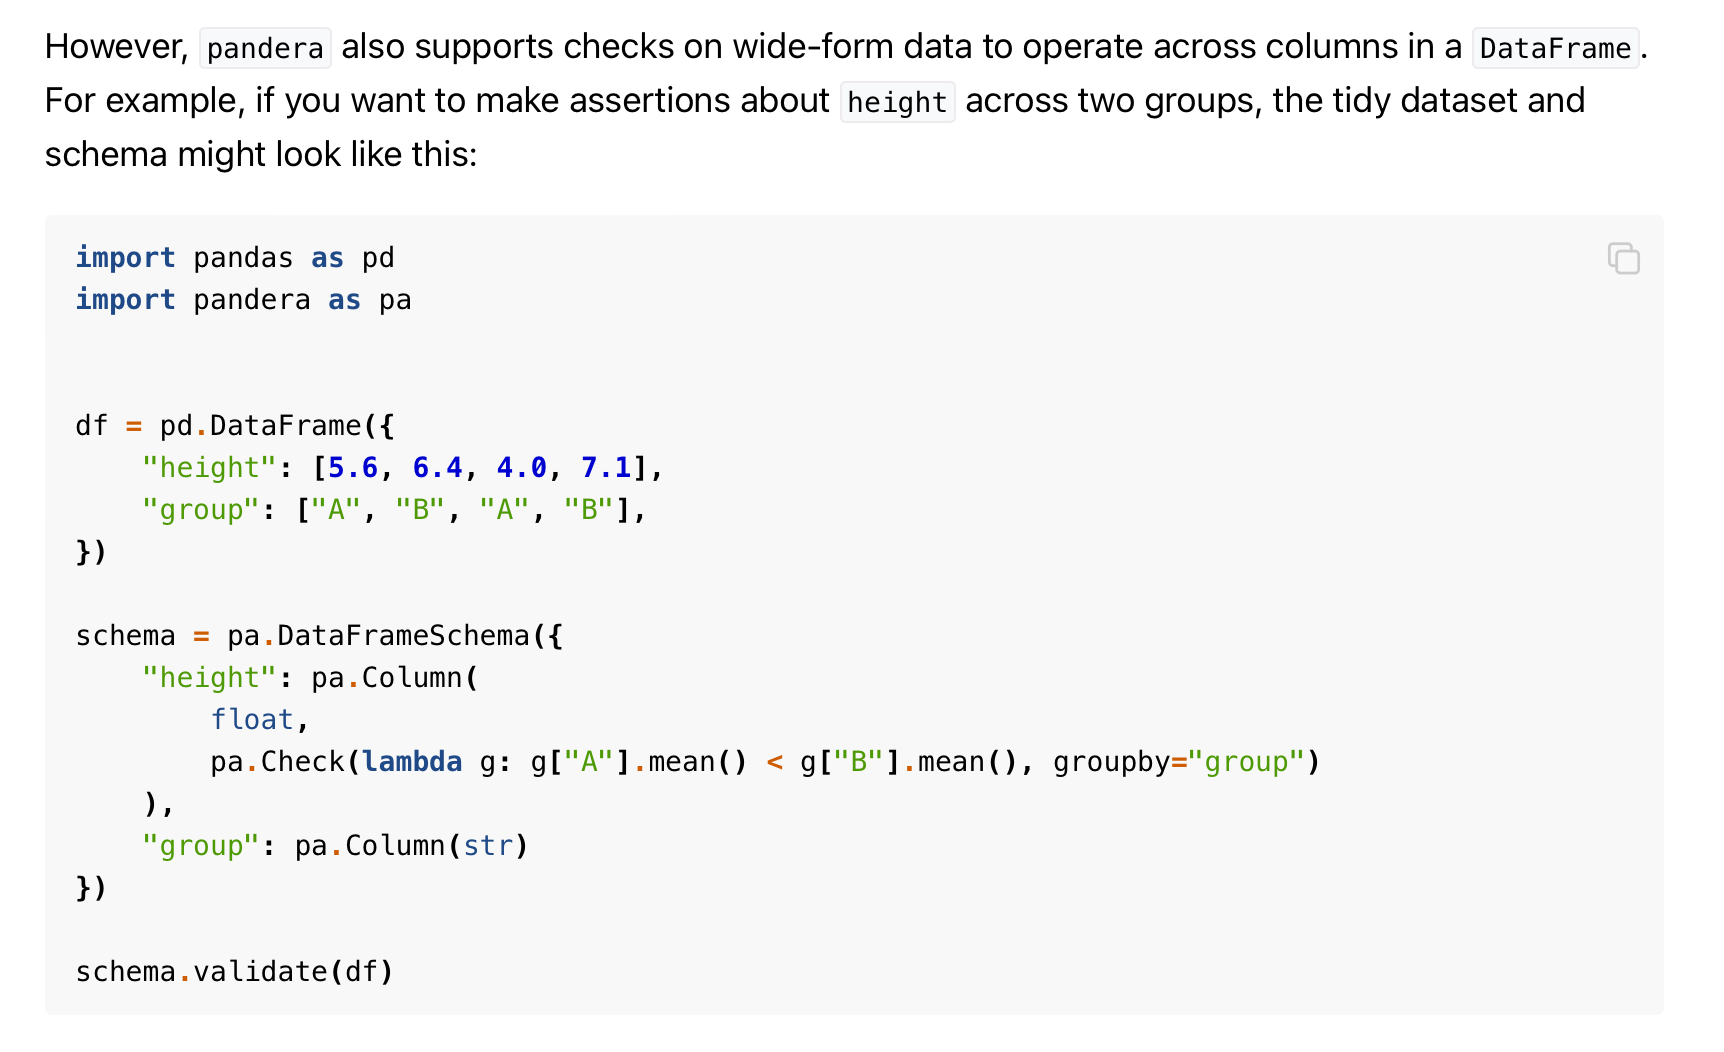

readme:  
    ```This file runs 3 validation checks on submitted 2023-A-10 form data, based on historical NTD validation errors.
    1. "Whole Number Facilities": Check that sum of total facilities for each agency, across all modes, is a whole number.
    2. "Non-zero Facilities" check: Check that the sum of all total facilities is not zero.
    3. "General Purpose Facility check": Check whether total gen purpose facilities (all but heavy maintenance) is > 1. If so mark as "failure".``` 